In [1]:
# imports and setting up file IO

import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#from keras import layers
from keras.layers import * #Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
#from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import * #Model, load_model
from vis.visualization import visualize_cam 
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

data_folder = r"C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyData"
notebook_save_folder = r"C:\Users\PerkLab\Desktop\HerniaModelStudy\SavedNotebooks"
model_save_folder = r"C:\Users\PerkLab\Desktop\HerniaModelStudy\SavedModels"

ultrasound_file = r"x_train_firstAndSecond_128.npy"
segmentation_file = r"y_train_firstAndSecond_128.npy" 
prediction_file=r""

test_ultrasound_file = r"x_test_third_128.npy"
test_segmentation_file = r"y_test_third_128.npy"
test_prediction_file=r"prediction-test.npy"

ultrasound_size = 128

model_to_validate_path = r"C:\Users\PerkLab\Documents\HerniaModelStudy\SavedModels\model_2019-07-30_00-09-33.h5"

train_model = True

classes = ['None', 'Skin', 'Fat', 'Extob', 'Spchd', 'Sack']
classes = ['Extob', 'Fat', 'None', 'Sack', 'Skin', 'Spchd']

resized_image_size = 128

# if not os.path.exists(training_data_path):
#     print("Could not find folder: " + training_data_path)
#     raise

# if not os.path.exists(testing_data_path):
#     print("Could not find folder: {}".format(testing_data_path))
#     raise
    
# if not os.path.exists(validation_data_path):
#     print("Could not find folder: {}".format(validation_data_path))
#     raise
    
# if not os.path.exists(second_validation_data_path):
#     print("Could not find folder: {}".format(second_validation_data_path))
#     raise


Using TensorFlow backend.


In [2]:
ultrasound_fullname = os.path.join(data_folder, ultrasound_file)
segmentation_fullname = os.path.join(data_folder, segmentation_file)

print("Reading images from:  {}".format(ultrasound_fullname))
print("Reading labels from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))


Reading images from:  C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyData\x_train_firstAndSecond_128.npy
Reading labels from:      C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyData\y_train_firstAndSecond_128.npy

Found 26209 ultrasound images and 26209 segmentations


Reading test ultrasound from: C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyData\x_test_third_128.npy
Reading test segmentation from : C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyData\y_test_third_128.npy

Found 2061 test ultrasound images and 2061 segmentations
(128, 128, 3)


Text(0.5, 1.0, '0.0')

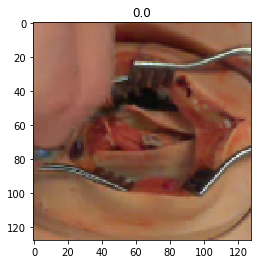

In [3]:
test_ultrasound_fullname = os.path.join(data_folder, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_folder, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname) 
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))
print(test_ultrasound_data[0].shape)

imgplot = plt.imshow(test_ultrasound_data[110]/255.0)
plt.title(str(test_segmentation_data[110]))

In [4]:
import keras.utils
import scipy.ndimage


max_rotation_angle = 30

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=3,
                 n_classes=6,
                 isTrain=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        self.isTrain = isTrain
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size)) # removed dim
#         print("x.shape is {}".format(str(x.shape)))
#         print(x)
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2) 
            if flip_flag == 1 and self.isTrain:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                #y[i] = np.flip(self.y[batch_indexes[i]]) # removed 2 ,; from each slice operation # changede axis 1 to 0
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
            y[i] = self.y[batch_indexes[i]] # removed 2 ,: from each slice operation
#         print("x.shape is {} after flip".format(str(x.shape)))
#         print(x)
        if self.isTrain:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        else:
            angle = 0
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
        #y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
#         print("x_rot.shape is {} after rotation".format(str(x_rot.shape)))
#         print(x_rot)
        y_rot = y
        
        x_rot = x_rot / 255.0
        #x_rot = np.clip(x_rot, 0.0, 1.0)
        #y_rot = np.clip(y_rot, 0.0, 1.0)
#         print("x_rot.shape is {} after clipping".format(str(x_rot.shape)))
#         print(x_rot)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

(4, 6)
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]


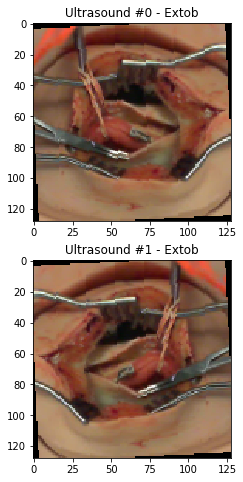

In [5]:
#testing batch generator

batch_size = 4
num_show = 2

tgen = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_data, batch_size, shuffle=False, isTrain=True)

bx, by = tgen.__getitem__(3)

print(by.shape)

import matplotlib.pyplot as plt

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show,3,i*3+1)
    img1 = a1.imshow(bx[i, :, :, :]) #, vmin=0.0, vmax=1.0)
    a1.set_title("Ultrasound #{} - {}".format(i, classes[np.argmax(by[i])]))
    print(by[i])
#     c = fig.colorbar(img1)
#     a2 = fig.add_subplot(num_show,3,i*3+2)
#     img2 = a2.imshow(by[i, :, :, 0], vmin=0.0, vmax=1.0)
#     a2.set_title("Class 0 #{}".format(i))
#     c = fig.colorbar(img2)
#     a3 = fig.add_subplot(num_show,3,i*3+3)
#     img3 = a3.imshow(by[i, :, :, 1], vmin=0.0, vmax=1.0)
#     a3.set_title("Class 1 #{}".format(i))
#     c = fig.colorbar(img3)

In [53]:
# define the model
from keras.regularizers import l2, l1

def HappyModel():
    X_input = Input(shape = (resized_image_size, resized_image_size, 3), name = 'X_input')
 
    X = Conv2D(4, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X_input)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Conv2D(8, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(16, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X)
    X = Dropout(0.3)(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(32, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X)
    X = Dropout(0.3)(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(32, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X)
    X = Conv2D(64, (3, 3), strides = (1,1) , padding = 'valid', activation = 'relu', activity_regularizer=l1(0.00001))(X)
    X = Dropout(0.3)(X)
    #X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Flatten()(X)

    X = Dense(len(classes) * 8 + 20, input_shape = (29 * 29 * 16, 1))(X)
    X = Activation('relu')(X)
    X = Dropout(0.3)(X)
 
    X = Dense(len(classes) * 4 + 10)(X)
    X = Activation('relu')(X)
 
    X = Dense(len(classes))(X)
    X = Activation('softmax')(X)
    
    return Model([X_input], [X])

if train_model:
    model = HappyModel()
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
#                      activation='relu',
#                      input_shape=(resized_image_size, resized_image_size, 3)))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(64, (5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(len(classes), activation='softmax'))
else:
    model = load_model(model_to_validate_path)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 126, 126, 4)       112       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 4)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 61, 61, 8)         296       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 16)        1168      
_________________________________________________________________
dropout_30 (Dropout)         (None, 28, 28, 16)        0         
__________

In [62]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(resized_image_size, resized_image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) # 2 because we have cat and dog classes

In [63]:
# train the model

if train_model:
    
    batch_size = 32
    
    num_epochs = 20

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_data, batch_size, isTrain=True)
    test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data, batch_size, isTrain=False)

    training_time_start = datetime.datetime.now()

    history = model.fit_generator(training_generator,
                                       validation_data=test_generator,
                                       epochs=num_epochs,
                                       verbose=1)
else:
    print("Training skipped, using loaded model. ")

Epoch 1/20
819/819 [==============================] - 60s 73ms/step - loss: 1.1012 - acc: 0.6149 - val_loss: 13.3263 - val_acc: 0.1680
Epoch 2/20
819/819 [==============================] - 57s 70ms/step - loss: 0.4952 - acc: 0.8276 - val_loss: 13.2718 - val_acc: 0.1704
Epoch 3/20
819/819 [==============================] - 57s 70ms/step - loss: 0.3815 - acc: 0.8673 - val_loss: 6.7266 - val_acc: 0.3071
Epoch 4/20
819/819 [==============================] - 57s 70ms/step - loss: 0.3564 - acc: 0.8732 - val_loss: 8.6499 - val_acc: 0.2412
Epoch 5/20
819/819 [==============================] - 57s 69ms/step - loss: 0.2832 - acc: 0.9015 - val_loss: 9.8357 - val_acc: 0.2192
Epoch 6/20
819/819 [==============================] - 57s 70ms/step - loss: 0.2636 - acc: 0.9082 - val_loss: 12.5889 - val_acc: 0.1753
Epoch 7/20
819/819 [==============================] - 57s 70ms/step - loss: 0.2421 - acc: 0.9146 - val_loss: 11.3010 - val_acc: 0.2222
Epoch 8/20
819/819 [==============================] - 57s 

In [64]:
# print out time info
if train_model:
    training_time_stop = datetime.datetime.now()
    print("Training started at: {}".format(training_time_start))
    print("Training stopped at: {}".format(training_time_stop))
    print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-08-03 14:49:41.191749
Training stopped at: 2019-08-03 15:08:46.342427
Total training time: 0:19:05.150678


In [65]:
#print(history)

In [66]:
# get the loss and accuracy of the model on the validation set
#results = model.evaluate_generator(valid_generator, len(valid_generator))
#results = model.evaluate_generator(valid_generator, 1000)
#print(model.metrics_names)
#print(results)

In [67]:
# get the loss and accuracy of the model on the second validation set
#second_results = model.evaluate_generator(second_valid_generator, len(second_valid_generator))
# print(model.metrics_names)
# print(second_results)

In [68]:
# train_generator.reset()
# total = 0
# correct = 0
# while total< 1000:
#     try:
#         x, y = train_generator.next()
#     except:
#         break

#     pred = model.predict(x)
#     pred1 = np.argmax(pred, axis=1)
#     pred2 = np.zeros((pred1.shape[0], 6))
#     try:
#         pred2[np.arange(pred1.shape[0]), pred1] = 1
#     except IndexError:
#         print("Uh Oh")
#         print(pred1.shape[0])
#         print(pred2)
#         print(pred1)
#     #print(pred1)
#     #print(pred2)
#     #print(y)

#     for i in range(pred1.shape[0]):
#         #print(pred2[i])
#         #print(y[i])
#         total+=1
#         if np.array_equal(pred2[i], y[i]):
#             correct +=1
#     print(correct/total)
    
# print(total)

# pred = model.predict(x)
# pred1 = np.eye(6)[pred]

# np.argmax(pred, axis=1)
# y


In [69]:
# make some predictions
# predictions = model.predict_generator(valid_generator, 1)
# vec_predicts = np.zeros(predictions.shape)
# for row in range(vec_predicts.shape[1]):
#     vec_predicts[row][np.argmax(predictions[row])] = 1
#vec_predicts
    
    

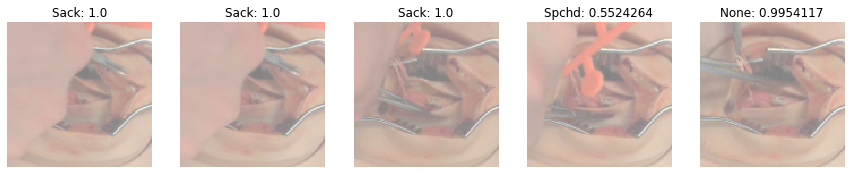

In [70]:
# show some results

#test_generator.reset()
x,y = test_generator.__getitem__(5)

num_choices = 5
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices):
    im = x[random_choice[i]][:,:,:]
    prediction = model.predict(np.expand_dims(im, 0))
    plt.subplot(1, num_choices, i+1)
    max_index = np.argmax(prediction[0])
    plt.title(str(classes[max_index]) + ": " + str(prediction[0][max_index]))
    plt.imshow((im + 1)/2)
    plt.axis('off')

In [71]:
def plots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :], cmap='gray')

def cplots(ims, figsize=(20,6), rows=1, titles=None):
    print(np.amax(ims.flatten()))
    m = np.amax(ims.flatten())
    ims = [x / m for x in ims]
    #ims/=np.amax(np.ndarray.flatten(ims))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :])

(5, 128, 128)
0


C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\PerkLab\Anaconda3\envs\hernia\lib\site-packages\matplotlib\colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(va

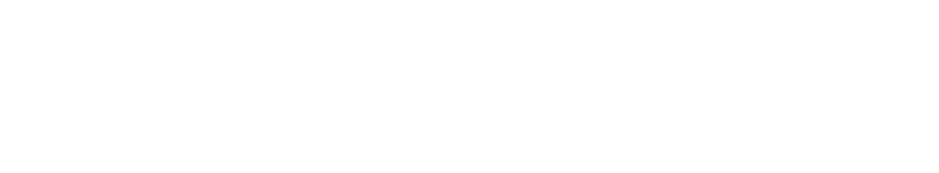

In [72]:
from vis.visualization import visualize_saliency
n_images= 5
start_index = 5
heat_map = np.zeros((n_images, resized_image_size, resized_image_size), dtype = int)
print(heat_map.shape)
#test_generator.reset()
for i in range(n_images//batch_size):
    x, y = test_generator.__getitem__(i)
    heat_map[i][:,:] = visualize_cam(model, 14, None, x[i][:,:,:])
#print(heat_map)
#cplots(heat_map[:n_images], figsize=(20,5), rows=1)
cplots(heat_map[:n_images], figsize=(20,5), rows=1)

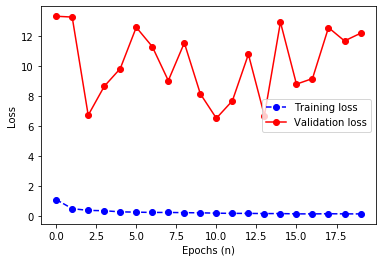

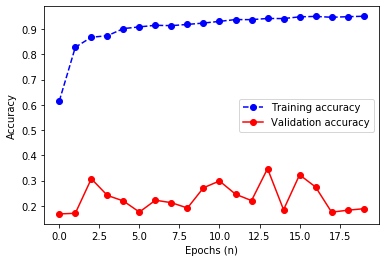

In [73]:
# graphical results

plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['acc'], 'bo--')
plt.plot(history.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [74]:
# save the results and model
if train_model:
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    if not os.path.exists(model_save_folder):
        os.makedirs(model_save_folder)
        print("Creating folder: {}".format(model_save_folder))

    model_file_name = "model_" + timestamp + ".h5"
    model_file_fullname = os.path.join(model_save_folder, model_file_name)

    model.save(model_file_fullname)
    print("Model saved to: {}".format(model_file_fullname))

    notebook_file_name = "notebook_" + timestamp + ".html"
    notebook_file_fullpath = os.path.join(notebook_save_folder, notebook_file_name)

    if not os.path.exists(notebook_save_folder):
        os.makedirs(notebook_save_folder)
        print("Creating folder: {}".format(notebook_save_folder))

    os.system("jupyter nbconvert --to html TrainHappyModel.ipynb --output " + notebook_file_fullpath)

    print("Notebook saved to: {}".format(notebook_file_fullpath))
else:
    print("Nothing saved becuase model not retrained. ")

Model saved to: C:\Users\PerkLab\Desktop\HerniaModelStudy\SavedModels\model_2019-08-03_15-08-47.h5
Notebook saved to: C:\Users\PerkLab\Desktop\HerniaModelStudy\SavedNotebooks\notebook_2019-08-03_15-08-47.html
